In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error


In [3]:
# Get data
df = pd.read_csv("../Data/airline_passengers.csv",
                 index_col = 'Month',
                 parse_dates = True)
df.head()
df.index.freq = 'MS'

# Log transform
df['LogPassengers'] = np.log(df['Passengers'])

df['DiffLogPassengers'] = df['LogPassengers'].diff()

series = df['DiffLogPassengers'].dropna().to_numpy()

# SPlit test and train
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

# Create AR like data
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
# Reshape Data D = 1 in this case
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
print(X.shape, Y.shape)
N = len(X)

(133, 10, 1) (133,)


In [4]:
# Split train and test
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

# LSTM model

In [5]:
# Make an RNN
M = 5 # nuumber of hidden units
i = Input(shape = (T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i, x)

Metal device set to: Apple M1 Pro


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 100,
    validation_data = (Xtest, Ytest)
    )

Epoch 1/100


2023-09-20 13:09:56.524815: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 3s 141ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 8/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 9/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 11/100
4/4 [============

Epoch 84/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 85/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 86/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 87/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 88/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 89/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 90/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 91/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 92/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 93/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 94/1

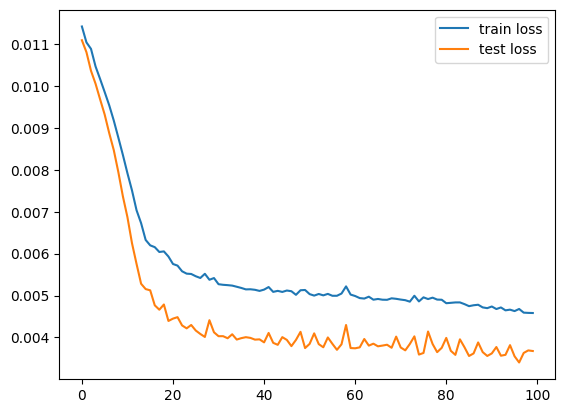

In [8]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

1/1 [==============================] - 0s 12ms/step


<Axes: xlabel='Month'>

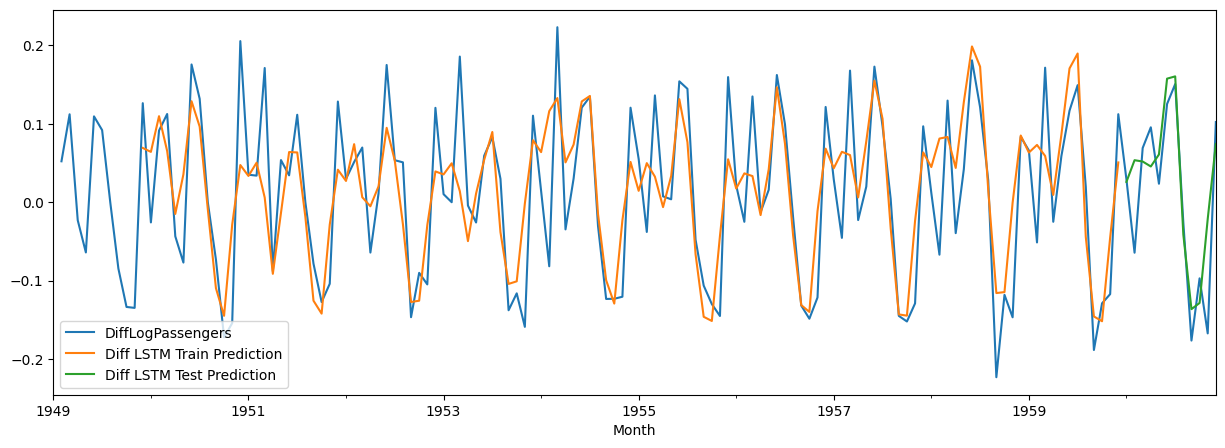

In [10]:
train_idx[:T+1] = False

Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

# Store diff predictions
df.loc[train_idx, 'Diff LSTM Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff LSTM Test Prediction'] = Ptest

# Plot the result
cols = ['DiffLogPassengers',
       'Diff LSTM Train Prediction',
       'Diff LSTM Test Prediction']
df[cols].plot(figsize = (15,5))


# 1 Step prediction

<Axes: xlabel='Month'>

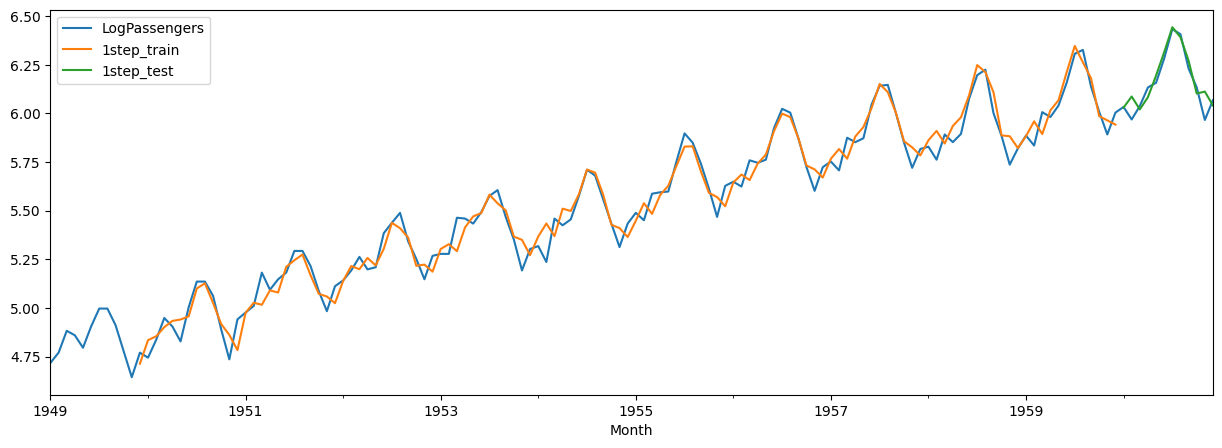

In [11]:
# undifference
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# Last-Known train vlaue
last_train = train.iloc[-1]['LogPassengers']

# 1-step forecast
df.loc[train_idx, "1step_train"] = prev[train_idx] + Ptrain
df.loc[test_idx, "1step_test"] = prev[test_idx] + Ptest

# Plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize = (15, 5))

# Multi step prediction

1/1 [==============================] - 0s 13ms/step


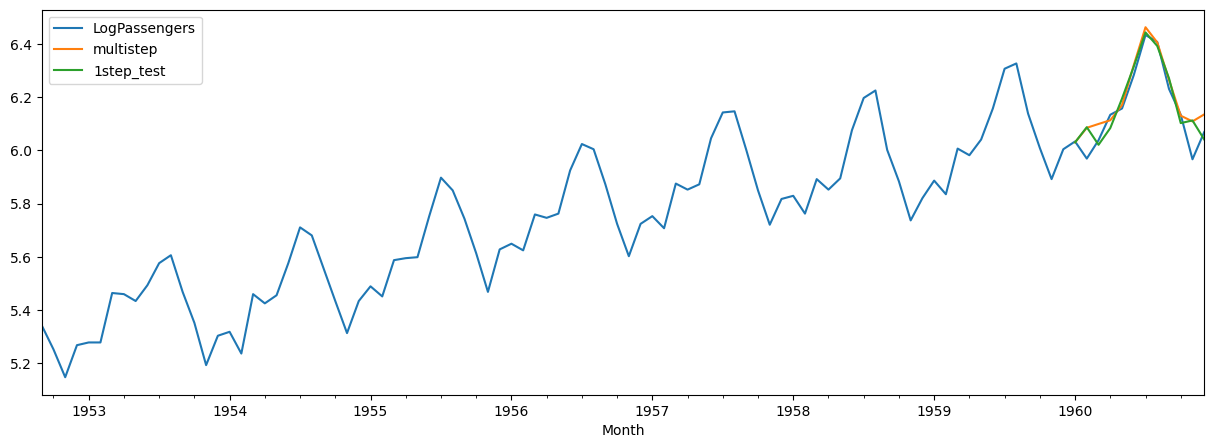

In [12]:
# Multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
    
    multistep_predictions.append(p)
    
    last_x = np.roll(last_x,-1) # [1,2,3] -> [2,3,1]
    last_x[-1] = p # Replace the last value with the predicted value

# Save prediction
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

# plot 1-step, multistep forecast
df.iloc[-100:][['LogPassengers', 'multistep', '1step_test']].plot(figsize = (15, 5));

# Multi Output Forecast

In [13]:
# Create AR like data
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t: t+Tx]
    X.append(x)
    
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    

# Reshape Data
X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print('X.shape', X.shape, 'Y.shpae', Y.shape)

X.shape (122, 10, 1) Y.shpae (122, 12)


Epoch 1/200
4/4 [==============================] - 2s 195ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 4/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 8/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 9/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 10/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 11/200
4/4 [

Epoch 84/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 85/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 86/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0066
Epoch 87/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 88/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 89/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 90/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 91/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0063
Epoch 92/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 93/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 94/2

4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 167/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 168/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 169/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 170/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 171/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 172/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 173/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 174/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 175/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 176/200


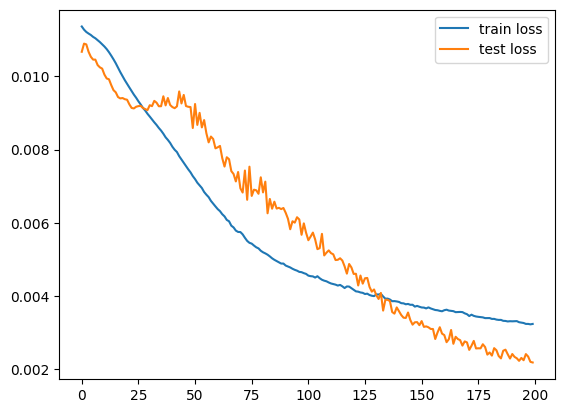

In [14]:
# Split train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

# Make an RNN
M = 5 # nuumber of hidden units
i = Input(shape = (T, 1))
x = LSTM(24, return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model = Model(i, x)

model.compile(
    loss = 'mse',
    optimizer = 'adam',
)

r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs = 200,
    validation_data = (Xtest_m, Ytest_m)
)

plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

1/1 [==============================] - 0s 16ms/step


<Axes: xlabel='Month'>

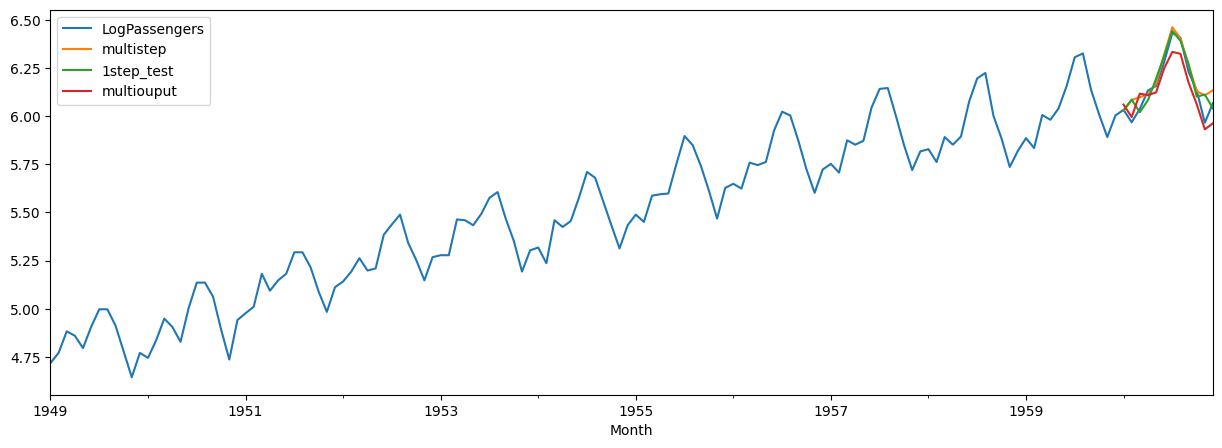

In [16]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

# AR like X values arel ike [y1 y2 y3] , [y2, y3, y4], so take the first col only
Ptrain = Ptrain[:,0] 
Ptest = Ptest[0]

# Store diff predictions
df.loc[test_idx, 'multiouput'] = last_train + np.cumsum(Ptest)

# Plot the result
cols = ['LogPassengers',
        'multistep', 
        '1step_test',
       'multiouput']
df[cols].plot(figsize = (15,5))


In [17]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multistep: ", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multiouput'])
print("multioutput: ", mape2)

multistep:  0.007263551582556208
multioutput:  0.00906085884975494
